In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt # type: ignore
import numpy as np
import polars as pl

In [3]:
from dspy.hdb import get_dataset

In [4]:
RCS = [f"{coin}USDT" for coin in ["BTC", "ETH", "SOL", "DOGE", "LINK"]]
TIMES = ['250120.000100', '250120.215000']

# <font color="grey">Data loading and handling</font>

Data is available in two forms: limit order book (LOB) and trade data. The timestamps are given in nanosecond resolution as Unix timestamps, but the granularity of the data is not that fine. A simple dataloader and some helper function to convert Python datetime objects or strings of the form '240802.1450' into timestamps are provided. The 'book' data contains best bid and ask prices with corresponding volumes. The 'trade' data contains trades, with a signed quantity representing direction. There is also an associated trade id in order to identify individual trades.

In [5]:
dl = get_dataset("terank")

####  <a id='chapter1'> <font color="grey">1. Book</font></a>

In [6]:
df = dl.load_book(RCS[0:2], TIMES, lazy=True)
# Add human readable timestamp and mid prices
df = df.ds.add_datetime('ts').feature.add_mid(products=RCS[0:2])

In [7]:
# This takes some time, not because of the loading but because of the aggregation
df = df.collect()
df.head()

ts,prc_s0_BTCUSDT,prc_s1_BTCUSDT,vol_s0_BTCUSDT,vol_s1_BTCUSDT,prc_s0_ETHUSDT,prc_s1_ETHUSDT,vol_s0_ETHUSDT,vol_s1_ETHUSDT,dts,mid_BTCUSDT,mid_ETHUSDT
i64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],f64,f64
1737331260001000000,100950.2,100950.5,0.001,0.74,3201.16,3201.18,0.049,13.713,2025-01-20 00:01:00.001,100950.35,3201.17
1737331260005000000,100949.8,100950.5,0.019,0.74,3201.16,3201.18,0.049,13.713,2025-01-20 00:01:00.005,100950.15,3201.17
1737331260007000000,100949.8,100950.5,0.019,0.469,3201.16,3201.18,0.049,13.713,2025-01-20 00:01:00.007,100950.15,3201.17
1737331260008000000,100943.3,100945.3,0.002,0.001,3201.16,3201.18,0.049,13.713,2025-01-20 00:01:00.008,100944.3,3201.17
1737331260017000000,100943.3,100945.3,0.002,0.001,3201.16,3201.17,0.049,0.9,2025-01-20 00:01:00.017,100944.3,3201.165


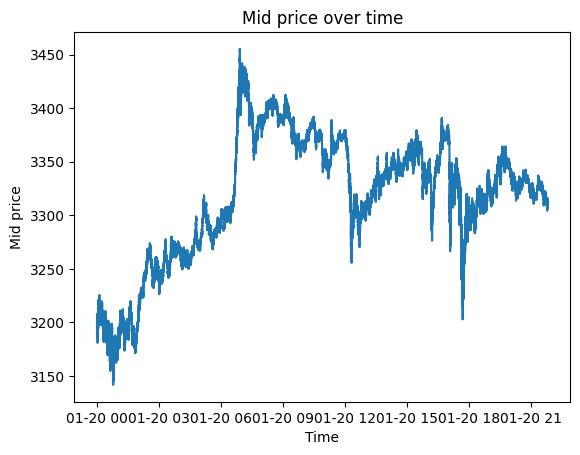

In [8]:
plt.plot(df['dts'], df[f'mid_{RCS[0]}'])
plt.xlabel('Time')
plt.ylabel('Mid price')
plt.title(f'{RCS[0]}')
plt.show()

In [8]:
# Add a column with random +1 or -1 entries
df = df.with_columns(
    pl.lit(np.random.choice([1., -1.], size=len(df))).alias('random_signal')
)

In [9]:
pdf = df.target.add_sig_pnl(ts_col="ts", col="mid_ETHUSDT", signal="random_signal", horizon="1m", in_bp=False)
pdf.head()

In [40]:
df = load_contract(update_type="bbo", contract_spec="BTCUSDT__BNCE_USDTM", times_range=TIMES[0][:-2]+":"+TIMES[1][:-2]).collect()   
sdf = df.select(['tse', 'prc_s0', 'prc_s1', 'vol_s0', 'vol_s1'])

In [41]:
ddf = load_contract(update_type="depth", contract_spec="BTCUSDT__BNCE_USDTM", times_range=TIMES[0][:-2]+":"+TIMES[1][:-2]).collect()
sddf = ddf.select(['tse', 'prc_s0', 'prc_s1', 'vols_s0', 'vols_s1'])

In [ ]:
print(df.collect().shape)
print(ddf.collect().shape)

In [ ]:
print(df.columns)
print(ddf.columns)

In [ ]:
print(df.head())
print(ddf.head())

In [51]:
sdf = df.select(['tse', 'prc_s0', 'prc_s1', 'vol_s0', 'vol_s1']).ds.add_datetime('tse')
sddf = ddf.select(['tse', 'prc_s0', 'prc_s1', 'vols_s0', 'vols_s1']).ds.add_datetime('tse')

In [73]:
diff_count = ddf.filter(pl.col('tse') != pl.col('tst'))




In [ ]:
diff_count = diff_count.select(['tse', 'tst']).with_columns((pl.col('tse') - pl.col('tst')).alias('diff')).head()

In [ ]:
# To get the values from a Polars Series, use .to_list() or .unique() to see distinct values
print("Unique differences between tse and tst:")
print(diff_count['diff'].unique())

# Alternative way to see all values
print("\nAll difference values:")
print(diff_count['diff'].to_list())

In [ ]:
sdf[:20]

In [ ]:
sddf.head()

In [12]:
df = df.feature.add_vwap(cols=["prc__s0", "prc__s1", "vol__s0", "vol__s1"])
df.head()

####  <a id='chapter2'> <font color="grey">2. Trades</font></a>

In [25]:
TIMES = ['250101.100000', '250101.120000']
products = ['BTCUSDT', 'ETHUSDT']

In [26]:
tdf = dl.load_trades(products, TIMES, lazy=True)
# By default, the timestamp column is named 'ts'
tdf = tdf.trade.agg_trades().trade.add_side().ds.add_datetime()

In [ ]:
tdf = tdf.collect()
tdf.head()

In [28]:
from trpy_data.data.load_data import load_contract

In [38]:
df = load_contract(update_type="depth", contract_spec="BTCUSDT__BNCE_USDTM", times_range="250101.1000:250101.1200")

In [ ]:
df = df.collect()

In [ ]:
df['vols_s0'][3]

In [ ]:
df.head()